# Clasificación de latidos cardíacos

## Introducción

Este trabajo práctico consiste en la clasificación de latidos cardíacos en 4 clases: Normales, Ventriculares Prematuros, Supraventriculares Prematuros, y Nodales Prematuros. Los resultados deben ser presentados mediante la matriz de confusión, la sensibilidad, especificidad, valor predictivo positivo y valor predictivo negativo.

La señal de electrocardiograma (ECG) fue obtenida de la grabación número 14172 de la base de datos "Long-Term Database" de Physionet, así como también las anotaciones de las clases de cada latido. Dicha grabación contiene 66413 latidos pero tras descartar los dos latidos iniciales y finales, y aquellos cuya clase no estaba determinada, el dataset final cuenta con 66000 latidos de los cuales:

* 58319 son latidos normales
* 6530 son latidos ventriculares prematuros
* 1003 son latidos supraventriculares prematuros
* 148 son latidos nodales prematuros


In [1]:
import numpy as np
import wfdb

from IPython.display import Image

def loadData(recordNum, db):
    ecgs, fields = wfdb.io.rdsamp('14172', channels=[0,1],  pb_dir = 'ltdb')
    ecgs = np.transpose(ecgs)
    return ecgs, fields

def getSamplingFreq(fields):
    fs = fields.get("fs")
    return fs

def getAnnPeaks(recordNum, db):
    ann = wfdb.io.rdann('14172', 'atr', pb_dir = 'ltdb', return_label_elements=['symbol'])  
    peaks = ann.sample
    return ann, peaks

def ECGsingleChannel(ecgs):
    return ecgs[0][:] - np.mean(ecgs[0][:])


ecgs, fields = loadData('14172', 'ltdb')
fs = getSamplingFreq(fields)
ann, peaks = getAnnPeaks('14172', 'ltdb')

print('Datos cargados\n')

sch_ecg = ECGsingleChannel(ecgs)

Datos cargados



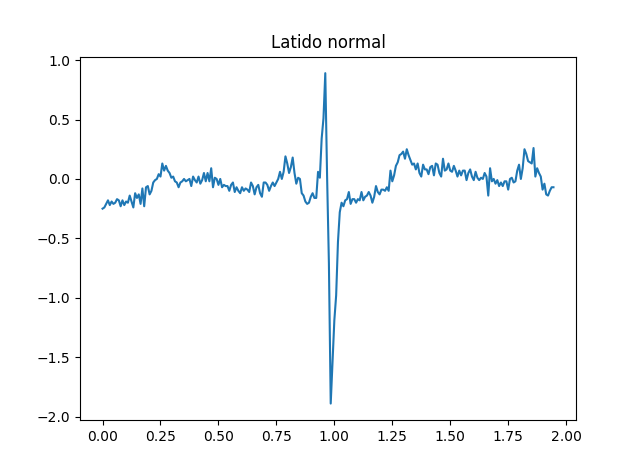

In [2]:
Image("Imgs/Normal.png")

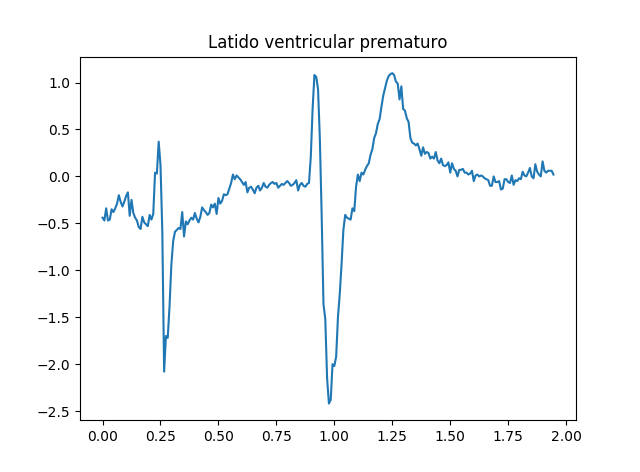

In [3]:
Image("Imgs/Ventricular.png")

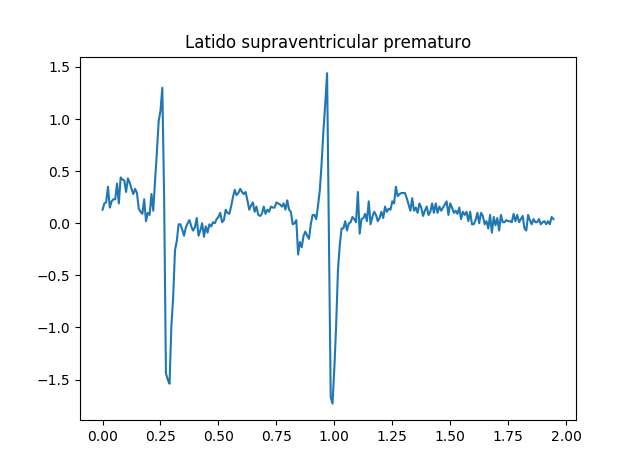

In [4]:
Image("Imgs/Supraventricular.png")

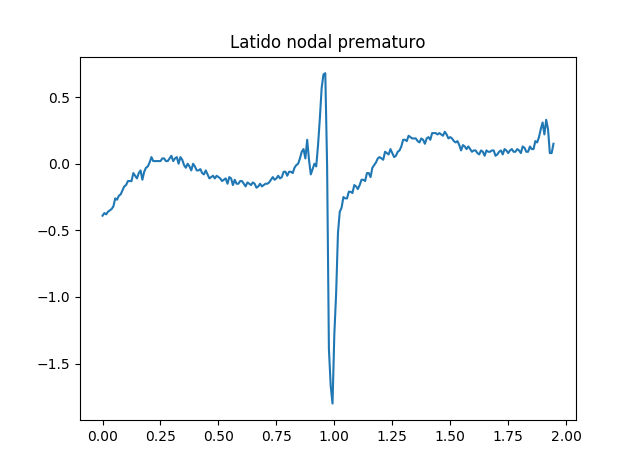

In [5]:
Image("Imgs/Nodal.png")

## Preprocesamiento

Las señales de origen biológico se ven afectadas por distintos tipos de ruido. En el caso de las señales de Electrocardiograma, se ven afectadas por ruidos provenientes de la alimentación de línea, ruido muscular, ruido proveniente de los movimientos y la respiración, y ruido por interferencias electromagnéticas.
En el ámbito del procesamiento de señales biomédicas, se utiliza mucho la descomposición Wavelet, tanto para el denoising, como para analizar el contenido de las bandas de frecuencia y extracción de features. 

Los latidos cardíacos tienen una forma de onda muy particular, exhibida en la siguiente figura. 

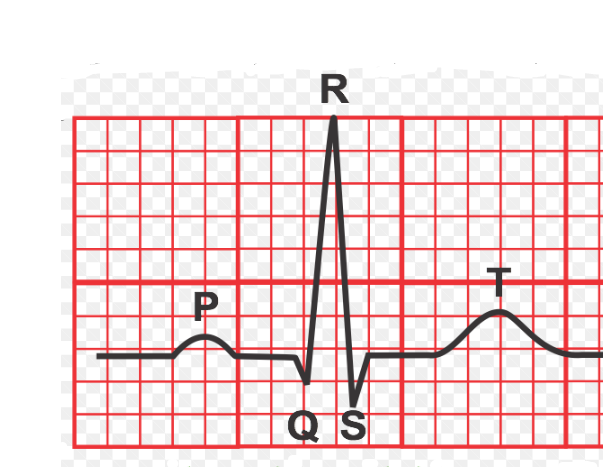

In [6]:
Image("Imgs/ecg.png")

Los componentes más significativos tienen la siguiente distribución de frecuencias [1] :

* Las ondas P y T tienen su contenido armónico entre 0.5 Hz y 10 Hz. 
* Los complejos QRS generalmente tienen un espectro comprendido entre 4 Hz y 20 Hz.

La DWT es un conjunto de filtros discretos que permiten descomponer a las señales en varias bandas cuya precisión en frecuencia va aumentando a medida que el rango de frecuencias de la subbanda disminuye y abarca frecuencia cada vez más bajas. El nivel de la descomposición determina cuántas bandas de frecuencia se analizan.

Con una frecuencia de muestreo de 128 Hz, se optó por hacer una descomposición de 8 niveles. La idea es localizar muy bien el baseline wander (ruido de muy baja frecuencia) para poder suavizarlo (junto con el ruido distribuido en el resto de las bandas). Para eso, una vez calculados los coeficientes wavelet se les aplicó soft-thresholding con umbral calculado por nivel [2]. Dicho umbral es representado por la fórmula:

$$ \delta_{N} = \sqrt{2\log(N)} \frac{\sigma_N}{\mu_N} $$

donde:

* N es el nivel de descomposición
* $\sigma_N$ es la mediana de los coeficientes dividido 0.6745, es decir $\sigma_N = \frac{med(C_N)}{0.6745}$
* $\mu_N$ es el máximo de los coeficientes de ese nivel


Respecto a la selección de la wavelet, tiene que usarse alguna que guarde parecido con la señal original para que pueda preservarse en buena parte. De las vistas en la bibliografía, las más usadas son las Coiflets y las de Daubechies. Finalmente, se seleccionó la familia Coiflets 2 por deformar menos la señal y por mostrar una mayor eliminación del baseline wander.

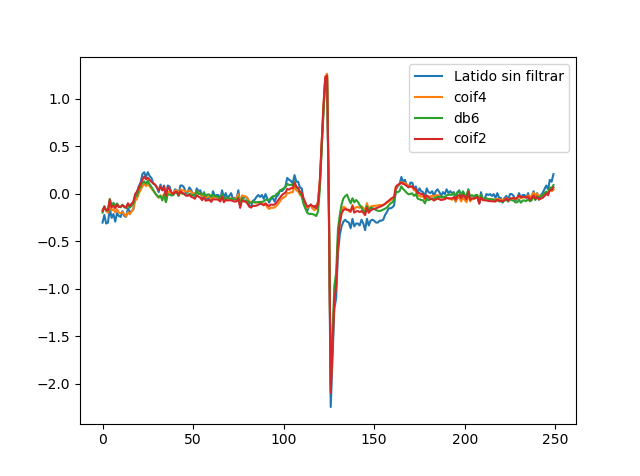

In [7]:
Image("Imgs/Filtwav_tiny.png")

A pesar de que hay trabajos que utilizan los coeficientes wavelet como features ya sea por su varianza [3], sus valores [4], o sus niveles para obtener información morfológica [5], por una cuestión de tener mayor posibilidad de consulta en el caso de ajustar el modelo, se optó por reconstruir la señal mediante la IDWT con los coeficientes con su umbral aplicado.

Datos filtrados con wavelets



D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Latidos segmentados y latidos inválidos descartados



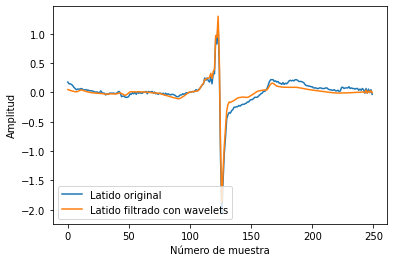

In [8]:
import pywt
import matplotlib.pyplot as plt
%matplotlib inline

## Funciones de preprocesamiento con wavelets

def calcMAD(cD):
    return np.median(np.abs(cD))

def thresholdCoeffs(cD,N):
    sigma = calcMAD(cD) / 0.6745
    mu = np.max( np.abs(cD) )
    thr = np.sqrt(2 * np.log10(N))* sigma / mu
    cD = pywt.threshold(cD, thr, 'soft')
    return cD

def waveletECGfilter(sch_ecg, wavelet, level):
    w = pywt.Wavelet(wavelet)
    coeffs = pywt.wavedec(sch_ecg, w, 'constant', level)        
    filt_coeffs = (coeffs[0],)
    for j in range(1, level + 1):
        filt_coeffs = filt_coeffs + (thresholdCoeffs(coeffs[j], len(coeffs[j])),)    
    ecg_filt = pywt.waverec(filt_coeffs,w)  
    return ecg_filt



# Descarte de los latidos que tienen notación dudosa

def getBeatType(symbol):
    beattype = 4
    if symbol == 'N':
        beattype = 0
    elif symbol == 'V':
        beattype = 1
    elif symbol == 'S':
        beattype = 2
    elif symbol == 'J':
        beattype = 3
    else:
        beattype = 4
    return beattype
    
def discardInvalidBeats(beats, beatsFilt, ann, peaks):
    tags = ann.symbol
    tags = np.delete(tags, (0))
    tags = np.delete(tags, (1))
    tags = np.delete(tags, (len(tags) - 2))
    tags = np.delete(tags, (len(tags) - 1))
    numberOfBeats = len(tags)
    beattype = np.zeros(numberOfBeats)
    discardedIdxs = []
    for i in range(numberOfBeats):
        beattype[i] = getBeatType(tags[i])
        if beattype[i] == 4:
            discardedIdxs.append(i)   
    for j in range(len(discardedIdxs)):
        beats = np.delete(beats, (discardedIdxs[j]), axis = 1)   
        beatsFilt = np.delete(beatsFilt, (discardedIdxs[j]), axis = 1)
        beattype = np.delete(beattype, (discardedIdxs[j]) )
        discardedIdxs = discardedIdxs - np.ones( np.shape(discardedIdxs) )
    return beats, beatsFilt, beattype



## Split de datos

def nullSpuriousPeaks(peaks):
    corrPeaks = peaks
    corrPeaks[0] = 0
    corrPeaks[1] = 0
    corrPeaks[-2] = 0
    corrPeaks[-1] = 0
    return corrPeaks

def beatSegmentation(ecg_filt, sch_ecg, halfbeatSize, peaks):
    corrPeaks = nullSpuriousPeaks(peaks)
    beatsCount = sum(corrPeaks > halfbeatSize)
    # Arreglo bidimensional de latidos, filas = cant. latidos, columnas = 
    # muestras de un determinado latido
    corrPeaks = corrPeaks[2:-2]
    beatsFilt = np.zeros([beatsCount, 2 * halfbeatSize])
    beats = np.zeros([beatsCount, 2 * halfbeatSize])
    
    idxlat = 0
    
    for i in corrPeaks :
        if i > halfbeatSize :
            beats [idxlat] = sch_ecg[ i - halfbeatSize : i + halfbeatSize ]                
            beatsFilt [idxlat] = ecg_filt[ i - halfbeatSize : i + halfbeatSize ] 
            idxlat += 1
            
    beats = np.transpose(beats)
    beatsFilt = np.transpose(beatsFilt)
        
    return corrPeaks, beats, beatsFilt

wvlt = 'coif2'
lvl = 8

ecg_filt = waveletECGfilter(sch_ecg, wvlt, lvl)
print('Datos filtrados con wavelets\n')
halfBeatSize = 125
corrPeaks, beats, beatsFilt = beatSegmentation(ecg_filt, sch_ecg, halfBeatSize, peaks)
beats, beatsFilt, beattype = discardInvalidBeats(beats, beatsFilt, ann, peaks)
print('Latidos segmentados y latidos inválidos descartados\n')

plt.plot(beats[:, 5])
plt.plot(beatsFilt[:, 5])
plt.xlabel('Número de muestra')
plt.ylabel('Amplitud')
plt.legend(['Latido original', 'Latido filtrado con wavelets'])

## Reducción de dimensionalidad

En esta etapa, es necesario reducir las dimensiones de los datos de cada latido (segmentados en 250 muestras centradas en cada pico R anotado) para obtener el mínimo de información necesario para que la red neuronal las pueda clasificar.

Para esto, los latidos fueron convertidos al espacio PCA. La cantidad de componentes preservadas fue determinada empíricamente de manera tal que la forma de la señal original se conserve de la mayor forma posible y que no se produzca una pérdida significativa de energía en las áreas clave de la forma de onda (como el complejo QRS). 

Datos reducidos con PCA



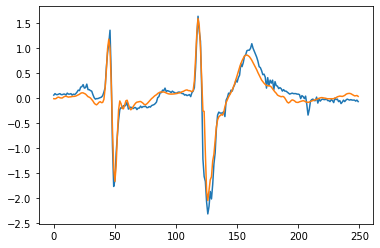

In [9]:
import numpy as np


## Acondicionamiento de datos para PCA
    
def normalizeBeats(beats):
    beatSize, beatsCant = np.shape(beats)
    means = np.zeros(beatSize)
    stds = np.zeros(beatSize)
    beatsNorm = np.zeros(np.shape(beats))
    for i in range(beatSize):
        means[i] = np.mean(beats[i, :]) #Hago la media sobre una muestra de cada latido
        stds[i] = np.std(beats[i, :])
    for idx in range(beatSize):    
        beatsNorm[idx] = beats[idx] - np.ones(beatsCant) * means[idx]
        beatsNorm[idx] = beatsNorm[idx] / stds[idx]
        
    return beatsNorm, means, stds    
    

## Reducción de dimensionalidad

def eigenSorted(beatsNorm):
    C = np.cov(beatsNorm)
    auval, auvec = np.linalg.eigh(C)
    idx = auval.argsort()[::-1]
    auval = auval[idx]
    auvec = auvec[:, idx]
    auvec = np.matrix.transpose(auvec)
    return auval, auvec 

def reduceDim(auvec, beatsNorm, compNumber):
    u = np.dot(auvec, beatsNorm)    
    beatSize = np.shape(beatsNorm)[0]
    u[compNumber : beatSize] = 0
    return u[0 : compNumber]

def restoreData(auvec, redBeats, origLength, means, stds):
    PCAcomps, numberOfBeats = np.shape(redBeats)
    nullArray = np.zeros( ((origLength - PCAcomps), numberOfBeats) )
    u = np.concatenate((redBeats, nullArray)) 
    restBeats = np.dot(np.matrix.transpose(auvec), u)
    for idx in range(origLength):
        restBeats[idx] = restBeats[idx] * stds[idx] + np.ones(numberOfBeats) * means[idx]
    return restBeats

def applyPCA(beatsNorm, compNumber):
    beatSize, beatCount = np.shape(beatsNorm)
    auval, auvec = eigenSorted(beatsNorm)
    reducedBeats = reduceDim(auvec, beatsNorm, compNumber)
    return reducedBeats, auval, auvec

compNumber = 50
beatsNorm, means, stds = normalizeBeats(beatsFilt)
reducedBeats, auval, auvec = applyPCA(beatsNorm, compNumber)
restoredBeats = restoreData(auvec, reducedBeats, len(beatsNorm), means, stds)
print('Datos reducidos con PCA\n')
plt.plot(beats[:, 8])
plt.plot(restoredBeats[:, 8])

## Rearmado del dataset

Normalmente, es necesario contar con 3 tipos de set de datos: los datos de entrenamiento, los datos de validación cruzada que sirven para chequear que el modelo entrenado cuenta con una precisión aceptable y los datos de test. Una regla práctica vista en foros y páginas de Machine Learning es que el modelo debe ser entrenado con un 80% de los datos y testeado con el 20% restante. También es aceptada la misma regla con una proporción de 70% / 30%. 

Sin embargo, dadas las características del problema, este particionamiento no produce buenos resultados. En lugar de eso, se tomó un dataset de entrenamiento (y validación cruzada) reducido, pero con suficientes muestras de los 4 tipos de latidos, de manera que todos se vean representados en la misma proporción. Para que el modelo se pueda ajustar mejor a la realidad, se consideró el efecto de la similaridad de los latidos que están más próximos entre sí.

En primer lugar, se contó en el dataset completo la cantidad de latidos de cada clase, y se los concatenó en orden decreciente de cantidad. Ahí se tomó una cantidad fija de manera aleatoria (pero con semilla para repetibilidad) de cada clase para armar los 3 dataset separados. Finalmente, se concatenó los arreglos de cada clase y se los mezcló mediante un nuevo shuffle. 

In [10]:
from keras.utils import to_categorical

## Generación de los datos de entrenamiento y prueba de la red
    
def rearrangeData(reducedBeats, beattype):
    dim, numberOfBeats = np.shape(reducedBeats)
    idxN = np.where(beattype == 0)
    idxV = np.where(beattype == 1)
    idxS = np.where(beattype == 2)
    idxJ = np.where(beattype == 3)
    Nbeats = reducedBeats[:, idxN]
    Vbeats = reducedBeats[:, idxV]
    Sbeats = reducedBeats[:, idxS]
    Jbeats = reducedBeats[:, idxJ]

    return Nbeats[:, 0], Vbeats[:, 0], Sbeats[:, 0], Jbeats[:, 0]


def splitDataSet(rearranged, trainBeats):
    
    userSeed = 7
    np.random.seed(userSeed)
    classes = len(rearranged)
    
    trList = []
    tstList = []
    trClass = []
    tstClass = []
    
    ## Obtengo un split por separado de cada tipo de latido
    for i in range(classes):
        # Transpongo la matriz de latidos para que no se haga el aleatorio
        # sobre los coeficientes PCA
        arr = np.transpose(rearranged[i])
        np.random.shuffle(arr)
        # Hago un split de dataset. La cantidad de entrenamiento no puede
        # exceder la cantidad de latidos nodales prematuros
        trCant = trainBeats
        trList.append(arr[0 : trCant])
        classCant = len(arr)
        trClass.append(np.full(trCant, i))
        tstCant = classCant - trainBeats
        tstList.append(arr[trCant:, :])
        tstClass.append(np.full(tstCant, i))
    
    ## Concateno las clases en los dataset y en los clases
    trArr = np.concatenate((trList[0], trList[1], trList[2], trList[3]), axis = 0)
    tstArr = np.concatenate((tstList[0], tstList[1], tstList[2], tstList[3]), axis = 0)
    
    trClassArr = np.concatenate((trClass[0], trClass[1], trClass[2], trClass[3]), axis = 0)
    tstClassArr = np.concatenate((tstClass[0], tstClass[1], tstClass[2], tstClass[3]), axis = 0)
    
    datasets = 2
    
    for j in range(datasets):
        if j == 0:
            idxs = np.arange(len(trArr))
            np.random.shuffle(idxs)
            trArr = trArr[idxs, :]
            trClassArr = trClassArr[idxs]
            trClassArr = to_categorical(trClassArr, num_classes = classes)
        elif j == 1:
            idxs = np.arange(len(tstArr))
            np.random.shuffle(idxs)
            tstArr = tstArr[idxs, :]
            tstClassArr = tstClassArr[idxs]   
            tstClassArr = to_categorical(tstClassArr, num_classes = classes)
            
    return trArr, trClassArr, tstArr, tstClassArr

Nbeats, Vbeats, Sbeats, Jbeats = rearrangeData(reducedBeats, beattype)
rearranged = (Nbeats, Vbeats, Sbeats, Jbeats)
print('Latidos ordenados\n')

tstBeats = 120
trArr, trClassArr, tstArr, tstClassArr1H = splitDataSet(rearranged, tstBeats)
print('Split de data set hecho\n')

Using TensorFlow backend.
D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: Future

Latidos ordenados

Split de data set hecho



## Implementación del modelo

En la literatura, se reseñan distintos modelos que permiten resolver el problema de clasificación: Random Forest[6], RBF[7], SVM[8]. Sin embargo, el más difundido y tradicionalmente utilizado es el del perceptrón multicapa.

En cuanto a la definición de la topología, la mayoría de los trabajos vistos coloca una única capa oculta. La capa de entrada tiene la misma cantidad de neuronas que la cantidad de features, y la capa de salida es de tamaño 4 por el número de clases. 
El número de unidades de la capa oculta es importante ya que una baja cantidad hace que el modelo no tenga suficiente capacidad de análisis de la información, mientras que un número excesivo puede generar overfitting. De acuerdo con [9], conviene que haya una cantidad intermedia entre unidades de salida y unidades de entrada, sugiere que no debe ser mayor a 2 veces el número de la capa de entrada y propone como número conveniente la siguiente cantidad:

$$N_{hiddenlayer} = \frac{2(N_{inputlayer} + N_{outputlayer})}{3}$$


El fuerte desbalance del dataset es problemático para reconocer los latidos con menor cantidad. Las medidas que suelen tomarse para mitigarlo son:

* aumentar las muestras de las clases menos representadas.

* asignar pesos a las clases, de manera que en la minimización de la función de costo se penalice de distinta forma los errores de clasificación.

En primera instancia, se asignó pesos teniendo en cuenta la proporción de latidos anormales respecto a los normales. Es decir, que los latidos normales tienen un peso unitario y los que no lo son tienen un peso determinado por el cociente entre los normales y dicha clase. El inconveniente es que hay un rango de pesos muy dispar que arroja muchos falsos positivos en las clases de menor cantidad.

Luego, para reducir el rango de coeficientes, se tomó el logaritmo en base 10 y logaritmo natural pero de esta forma los resultados se van al otro extremo, no se obtienen latidos minoritarios positivamente clasificados.

Vista la dificultad que reviste el ajuste de pesos, se prosiguió por la primer opción. Para no agregar muestras de otro dataset, se tomó un set de datos de entrenamiento reducido donde no se respeten las proporciones originales. De esta forma, se produce un "sobremuestreo" de las clases anormales.

Finalmente, se listan las características de la red, así como las medidas de regularización tomadas:

* Topología: 50 - 36 - 4
* Funciones de activación: relu / relu / softmax
* Función de costo: categorical cross-entropy
* Métrica: categorical accuracy
* Porcentaje de datos de validación: 30 % del set de entrenamiento
* Regularización L1 y L2
* Dropout: 10%

In [11]:
import numpy as np
import math

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout 
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

import h5py

def generateClassWeigths(Nnum, Vnum, Snum, Jnum):
    Wn = 1.0
    Wv = math.log10(np.floor(Nnum / Vnum))
    Ws = math.log10(np.floor(Nnum / Snum))
    Wj = math.log10(np.floor(Nnum / Jnum))
    weightDict = {0: Wn, 1: Wv, 2: Ws, 3: Wj}
    return weightDict  

## Muestro los resultados obtenidos
def getNumberCases(tstClass):
    Nres = len( np.where(tstClass == 1) )
    Vres = len( np.where(tstClass == 2) ) 
    Sres = len( np.where(tstClass == 3) )
    Jres = len( np.where(tstClass == 4) )
    return Nres, Vres, Sres, Jres

def fitNN(inputUnits, hiddenUnits, classes, compNumber, dropout_rate, trArr, trClassArr, tstArr):
    model = Sequential()
    model.add(Dense(inputUnits, activation = 'relu', input_dim = compNumber, kernel_regularizer = regularizers.l1_l2(0.01, 0.01), bias_regularizer = regularizers.l1_l2(0.01, 0.01)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hiddenUnits, activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense( classes, activation = 'softmax'))
    
    # En la página de Keras se sugiere esa función de pérdidas para clasificadores múltiples
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['categorical_accuracy'])
    earlyStopCall = [EarlyStopping(monitor='val_loss', patience=2),
                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    history = model.fit(trArr, trClassArr, epochs = 1000, callbacks = earlyStopCall, verbose = 1, validation_split = 0.3)
    tstResult = model.predict(tstArr, verbose = 1)
    return tstResult, history


# Grafico las curvas de la función de pérdida y el accuracy
def plotModelTraining(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

## Entreno mi modelo
inputUnits = compNumber
hiddenUnits = 24
classes = 4
outputUnits = classes
feats = compNumber
dropout_rate = 0.1

#tstResult1H, history = fitNN(inputUnits, hiddenUnits, classes, compNumber, dropout_rate, trArr, trClassArr, tstArr)

print('Modelo entrenado\n')


Modelo entrenado



## Resultados

En sistemas diagnósticos médicos, es importante tomar una serie de métricas de performance del algoritmo para describir los distintos tipos de error.

La matriz de confusión indica de forma resumida la cantidad de latidos que fueron correctamente clasificados y los que no, a qué clase fueron atribuidos.

Ahora, se deben realizar unas definiciones que ayudan a entender las otras formas de evaluación:

* $V_p$ son los verdaderos positivos para cierta clase.
* $V_n$ son los verdaderos negativos.
* $F_p$ son los falsos positivos.
* $F_n$ son los falsos negativos.

La sensibilidad mide la proporción de positivos entre los que efectivamente tienen la patología.

$$Sensibilidad = \frac{V_p}{V_p+F_n}$$

La especificidad indica la fracción de negativos en el grupo de los que no padecen la enfermedad estudiada.

$$Especificidad = \frac{V_n}{V_n+F_p}$$

El valor predictivo positivo expresa la probabilidad de tener la enfermedad habiendo recibido un diagnóstico positivo.

$$(PV+) = \frac{V_p}{F_p + V_p}$$

El valor predictivo negativo da la probabilidad de no tener la enfermedad si el diagnóstico resulta negativo.

$$(PV-) = \frac{V_n}{F_n + V_n}$$

In [12]:
import itertools
import pycm

from keras.models import load_model


def getModelMetrics(tstClassArr, tstResult):
    cm = pycm.ConfusionMatrix(tstClassArr, tstResult,digit=5)
    #cm.relabel(mapping={0:"N", 1:"V", 2:"S", 3:"J"})
    return cm    
 
    
## Función extraida de sklearn
def plot_metrics(cm, x_classes,
                          y_classes,
                          title='Métricas',
                          cmap=plt.cm.Blues):

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(x_classes))
    plt.xticks(tick_marks, x_classes, rotation=45)
    plt.yticks(tick_marks, y_classes)

    #fmt = '.2f' if normalize else 'd'
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Valores')
    plt.xlabel('Clases')
    plt.tight_layout()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' #if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()    

def decodeHotOneMatrix(mat1H):
    mat = np.zeros(len(mat1H))
    for i in range(len(mat1H)):
        mat[i] = np.argmax(mat1H[i, :])
    return mat

def printMetrics(tstClassArr1H, tstResult1H):

    tstClassArr = decodeHotOneMatrix(tstClassArr1H)
    tstResult = decodeHotOneMatrix(tstResult1H)
    
    cm = getModelMetrics(tstClassArr, tstResult)  
    

    C = cm.matrix
    print("Matriz de confusión:\n")
    cm.print_matrix()
    print("\n")
                
    
    print("True positives:")
    print(cm.TP)
    print("\n")
    print("True negatives:")
    print(cm.TN)
    print("\n")
    print("False positives:")
    print(cm.FP)
    print("\n")
    print("False negatives:")
    print(cm.FN)
    print("\n")
    
    
    sensitivity = cm.TPR
    specificity = cm.TNR
    ppv = cm.PPV
    npv = cm.NPV

    print("Sensibilidad:\n")
    print(sensitivity)
    print("\n")
    print("Especificidad:\n")
    print(specificity)
    print("\n")
    print("Valor predictivo positivo:\n ")
    print(ppv)
    print("\n")
    print("Valor predictivo negativo:\n")
    print(npv)
    print("\n")
    
    return cm 

### Muestro los resultados que quiero

#model = load_model('best_model.h5')
#tstResult1H = model.predict(tstArr, verbose = 1)
tstResult1H = np.load('tstResult1H.npy')
cm = printMetrics(tstClassArr1H, tstResult1H)
tstResult = decodeHotOneMatrix(tstResult1H)
tstClassArr = decodeHotOneMatrix(tstClassArr1H)

Matriz de confusión:

Predict          0.0      1.0      2.0      3.0      
Actual
0.0              48069    84       4168     5878     

1.0              2        6235     43       130      

2.0              194      12       660      17       

3.0              1        0        1        26       




True positives:
{0.0: 48069, 1.0: 6235, 2.0: 660, 3.0: 26}


True negatives:
{0.0: 7124, 1.0: 59014, 2.0: 60425, 3.0: 59467}


False positives:
{0.0: 197, 1.0: 96, 2.0: 4212, 3.0: 6025}


False negatives:
{0.0: 10130, 1.0: 175, 2.0: 223, 3.0: 2}


Sensibilidad:

{0.0: 0.8259420264953006, 1.0: 0.9726989079563183, 2.0: 0.7474518686296716, 3.0: 0.9285714285714286}


Especificidad:

{0.0: 0.9730911077721622, 1.0: 0.9983759093216038, 2.0: 0.9348360845955103, 3.0: 0.9080040310266903}


Valor predictivo positivo:
 
{0.0: 0.9959184519123192, 1.0: 0.9848365187174222, 2.0: 0.1354679802955665, 3.0: 0.004296810444554619}


Valor predictivo negativo:

{0.0: 0.41288976469224525, 1.0: 0.9970433695450

De la matriz de confusión, se desprenden algunos resultados a notar. Los latidos notados como '0' son los normales, los que tienen el número '1' son los ventriculares prematuros, el '2' corresponde a los supraventriculares prematuros, y el '3', a los nodales prematuros.

En principio, se puede notar una alta cantidad de latidos normales clasificados como no normales. Por las pruebas hechas antes del entrenamiento balanceado, esto puede deberse al peso que adquirieron los dos tipos de latido minoritario. 
En segunda instancia, también se ve una alta proporción de latidos supraventriculares clasificados como normales. Puede atribuirse a que morfológicamente son similares a los normales.

Finalmente, en los resultados positivos podemos destacar la alta tasa de detección de true positives en los nodales prematuros y en los ventriculares prematuros. Lo primero, es por efecto de la cantidad de muestras de entrenamiento en proporción a las de testeo (lo que llevó a un aumento de su peso relativo frente al resto de los tipos de latido), y el segundo caso es porque su morfología es muy distinta al resto de los latidos.

Considerando que donde se cometen errores mayormente es en la clasificación de latidos normales como anormales, y que solamente hay 197 latidos de 66520 erróneamente considerados sanos, se concluye que el sistema tiene una muy buena performance. 
Para mejoras futuras, convendría ajustar más finamente la cantidad de latidos de cada clase en el dataset (agregando muestras extra de los latidos que presentaron más error) o bien asignar distintos pesos en el entrenamiento a los mismos. También, se podría probar dándole más importancia a los coeficientes wavelet como features para extraer características morfológicas, o bien se podría incorporar la distancia entre picos R sucesivos.

## Referencias

[1] Adam Gacek and Witold Pedrycz.
\textit{ECG Signal Processing, Classification and Interpretation}.
Springer, London, 2012.

[2] Georgieva-Tsaneva, G., Tcheschmedjiev, \textit{Denoising of Electrocardiogram Data with Methods of Wavelet Transform}, CompSysTech'13 Local Proceedings, ISSN 1314-9687, pp. 9 - 16, 28-29 June 2013, Ruse, Bulgaria.

[3] Afsar, Fayyaz A., Arif, M. \textit{Robust Electrocardiogram Beat Classification using Discrete Wavelet Transform}, 2nd International Conference on Bioinformatics and Biomedical Engineering, ISSN 2151-7614, pp. 1867-1870, 16-18 May 2008, Shanghai, China.

[4] Dash, Sanjit K., Sasibhushana Rao, G., \textit{Robust Multiclass ECG Arrhythmia Detection Using Balanced Trained Neural Network}, International Conference on Electrical, Electronics, and Optimization Techniques (ICEEOT), ISBN: 978-1-4673-9939-5, pp. 186-191, 3-5 March 2016, Chennai, India.

[5] Emanet, Nahit., \textit{ECG Beat Classification by Using Discrete Wavelet Transform and Random Forest Algorithm} , 5th International Conference on Soft Computing, Computing with Words and Perceptions in System Analysis, Decision and Control, ISBN: 978-1-4244-3429-9, 2-4 Sept. 2009, Famagusta, Cyprus.

[6] Dewagan, Naveen K., Shukla, S. P., \textit{ECG Arrhythmia Classification using Discrete Wavelet Transform and Artificial Neural Network}, IEEE International Conference On Recent Trends In Electronics Information Communication Technology, ISBN: 978-1-5090-0774-5, May 20-21, 2016, India

[7] Ranaware, Preeti N., Deshpande, Rohini A., \textit{Detection of Arrhythmia based on Discrete Wavelet Transform using Artificial Neural Network and Support Vector Machine}, International Conference on Communication and Signal Processing, ISBN: 978-1-5090-0396-9, pp. 1767 - 1770, April 6-8, 2016, India

[8] Ghongadee, Rajesh, Ghatol, Ashok, \textit{A Robust and Reliable ECG Pattern Classification using QRS Morphological Features and ANN}, TENCON IEEE Region 10 Conference, ISSN: 2159-3442, November 19-21, 2008, Hyderabad, India.

[9] https://www.heatonresearch.com/2017/06/01/hidden-layers.html